# Required imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import shap
import mlflow

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler , OrdinalEncoder
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier

In [2]:
random_state = 12
folds = StratifiedKFold(n_splits = 5)
scorer = make_scorer(f1_score, average='macro')
dummie_columns = ['variable_4', 'variable_11', 'variable_16']
enc_column = 'State'

# Functions

In [3]:
def interact_value_counts(data):
    column = data.columns
    col_list = []
    for i in column:
            col_list.append(i)
    def series(col_name):
        for i in col_list:
            if col_name == i:
                print(data[i].value_counts())
        return
    print(interact(series, col_name = col_list))

In [4]:
def data_preprocessing(data, dummie_columns, enc_column):
    data = pd.get_dummies(data, columns=dummie_columns, dtype=np.int32)
    
    enc = OrdinalEncoder()
    data[enc_column] = enc.fit_transform(data[enc_column].values.reshape(-1, 1))[:, 0]
    
    data.drop('ID', axis=1, inplace=True)
    
    return data

In [5]:
def data_split_and_over_sampling(data, target, random_state):
    
    X_train, X_test, Y_train, Y_test = train_test_split(data.drop(target, axis=1),
                                                   data[target], test_size=0.25,
                                                   random_state=random_state, stratify=data[target])

    X_train, Y_train = SMOTE(random_state=random_state).fit_resample(X_train, Y_train)
    
    print(f'X_train shape is {X_train.shape}')
    print(f'Y_train shape is {Y_train.shape}')
    print(f'X_test shape is {X_test.shape}')
    print(f'Y_test shape is {Y_test.shape}')

    return X_train, X_test, Y_train, Y_test
    

In [6]:
def tuning(X_train, y_train, model, hyper_params, folds, scorer):
    
    model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params,
                        scoring=scorer, 
                        cv = folds)
        
    model_cv.fit(X_train, y_train)
    
    return model_cv.best_params_, model_cv.best_estimator_

In [7]:
def get_and_print_metrics(Y_true, Y_pred, model, X_train, Y_train):
    
    f1 = round(f1_score(Y_pred, Y_true, average='macro'), 2)
    prec = round(precision_score(Y_true, Y_pred), 2)
    recall = round(recall_score(Y_true, Y_pred), 2)
    
    metrics = {'f1_score': f1, 'precision': prec, 'recall': recall}
    
    print('Train f1_score: - ', f1_score(model.predict(X_train), Y_train, average='macro'))
    print('Test f1_score: - ', f1)
    
    print('confusion matrix')
    print(confusion_matrix(Y_true, Y_pred))
    print('classification report')
    print(classification_report(Y_true, Y_pred))
    
    return metrics

In [8]:
def create_experiment(experiment_name,run_name, run_metrics, model, run_params=None):
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")

In [9]:
def shap_values_plot(model, data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)
    data_array = np.array(data)

    shap.summary_plot(shap_values, data_array, feature_names=data.columns)

In [41]:
def get_probability(model, data, dummie_columns, enc_column):
    new_data = data_preprocessing(data, dummie_columns, enc_column)
    predict_proba = model.predict_proba(new_data)
    
    test = pd.DataFrame(predict_proba[:, 1], columns=['Probability'])
    test['ID'] = data['ID']
    
    prob = test.sort_values('Probability', axis=0, ascending=False, inplace=False)[:100]
    prob.reset_index(drop=True, inplace=True)
    
    return prob

# Data reading and preprocessing

In [4]:
train_data = pd.read_csv('train.csv')
train_data.head(3)

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,...,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,State,ID,target
0,120,2.51,6.60,0,0,9.3,16.69,186.7,4,15.87,...,0,146.7,85,99,96,408,2,GA,0,0
1,94,1.81,8.13,0,0,6.7,30.82,182.4,2,15.50,...,0,180.6,108,135,103,415,0,OH,1,0
2,82,3.00,4.93,0,0,11.1,24.46,194.9,2,16.57,...,0,109.6,105,61,94,510,1,DC,2,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   variable_0   3000 non-null   int64  
 1   variable_1   3000 non-null   float64
 2   variable_2   3000 non-null   float64
 3   variable_3   3000 non-null   int64  
 4   variable_4   3000 non-null   int64  
 5   variable_5   3000 non-null   float64
 6   variable_6   3000 non-null   float64
 7   variable_7   3000 non-null   float64
 8   variable_8   3000 non-null   int64  
 9   variable_9   3000 non-null   float64
 10  variable_10  3000 non-null   float64
 11  variable_11  3000 non-null   int64  
 12  variable_12  3000 non-null   float64
 13  variable_13  3000 non-null   int64  
 14  variable_14  3000 non-null   int64  
 15  variable_15  3000 non-null   int64  
 16  variable_16  3000 non-null   int64  
 17  variable_17  3000 non-null   int64  
 18  State        3000 non-null   object 
 19  ID    

In [6]:
train_data.describe()

,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,ID,target
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,101.271333,2.768620,9.039807,8.174333,0.100333,10.252167,30.592697,201.171100,4.479667,17.099747,179.953933,0.278667,200.883233,100.090000,100.325667,99.863667,437.183000,1.561000,1499.500000,0.148333
std,40.085841,0.750316,2.277167,13.747786,0.300494,2.779040,9.236061,50.920075,2.463522,4.328183,54.329868,0.448418,50.602550,19.938599,19.977186,19.675165,42.368761,1.319669,866.169729,0.355489
min,1.000000,0.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,0.000000,0.000000,33.000000,408.000000,0.000000,0.000000,0.000000
25%,73.750000,2.300000,7.520000,0.000000,0.000000,8.500000,24.475000,166.700000,3.000000,14.170000,143.975000,0.000000,167.000000,87.000000,87.000000,86.000000,408.000000,1.000000,749.750000,0.000000
50%,101.000000,2.780000,9.075000,0.000000,0.000000,10.300000,30.535000,201.400000,4.000000,17.120000,179.600000,0.000000,201.650000,100.000000,101.000000,100.000000,415.000000,1.000000,1499.500000,0.000000
75%,128.000000,3.270000,10.590000,20.000000,0.000000,12.100000,36.845000,235.225000,6.000000,19.992500,216.725000,1.000000,235.300000,114.000000,114.000000,113.000000,510.000000,2.000000,2249.250000,0.000000
max,243.000000,5.400000,17.770000,51.000000,1.000000,20.000000,59.640000,363.700000,20.000000,30.910000,350.800000,1.000000,395.000000,170.000000,165.000000,175.000000,510.000000,9.000000,2999.000000,1.000000


In [7]:
interact_value_counts(train_data)

interactive(children=(Dropdown(description='col_name', options=('variable_0', 'variable_1', 'variable_2', 'var…

<function interact_value_counts.<locals>.series at 0x7f03d44340d0>


In [14]:
data = data_preprocessing(train_data, dummie_columns, enc_column)
shap_data = data.drop('target' ,axis=1)
print(data.shape)
data.head()

(3000, 24)


,variable_0,variable_1,variable_2,variable_3,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,...,variable_17,State,target,variable_4_0,variable_4_1,variable_11_0,variable_11_1,variable_16_408,variable_16_415,variable_16_510
0,120,2.51,6.60,0,9.3,16.69,186.7,4,15.87,98.2,...,2,10.0,0,1,0,1,0,1,0,0
1,94,1.81,8.13,0,6.7,30.82,182.4,2,15.50,181.3,...,0,35.0,0,1,0,1,0,0,1,0
2,82,3.00,4.93,0,11.1,24.46,194.9,2,16.57,143.9,...,1,7.0,0,1,0,1,0,0,0,1
3,170,2.27,6.05,0,8.4,44.18,245.0,3,20.83,259.9,...,3,45.0,0,0,1,1,0,0,0,1
4,93,3.38,3.20,19,12.5,23.26,179.5,3,15.26,136.8,...,2,4.0,0,1,0,0,1,0,0,1


In [15]:
X_train, X_test, Y_train, Y_test = data_split_and_over_sampling(data, 'target', random_state)

X_train shape is (3832, 23)
Y_train shape is (3832,)
X_test shape is (750, 23)
Y_test shape is (750,)


# Modeling

# Logistic Regression

In [16]:
log_reg = LogisticRegression(random_state=random_state, solver='liblinear')
log_params = {'penalty':['l1', 'l2']}



log_best_params, log_best_model = tuning(X_train, Y_train, log_reg, log_params,
                                                folds, scorer)

log_reg_pred = log_best_model.predict(X_test)

In [18]:
log_model_metrics = get_and_print_metrics(Y_test, log_reg_pred, log_best_model, X_train, Y_train)
log_model_metrics

Train f1_score: -  0.8689856328127992
Test f1_score: -  0.67
confusion matrix
[[585  54]
 [ 65  46]]
classification report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       639
           1       0.46      0.41      0.44       111

    accuracy                           0.84       750
   macro avg       0.68      0.66      0.67       750
weighted avg       0.83      0.84      0.84       750



{'f1_score': 0.67, 'precision': 0.46, 'recall': 0.41}

In [ ]:
experiment_name = "Experiment_1" 
run_name = "Tuned_Logistic_Regression"
create_experiment(experiment_name, run_name, log_model_metrics, log_best_model, log_best_params)

# KNN

In [ ]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(5, 11),
              'metric': ['minkowski'],        
              'p':np.arange(1, 3),            
              'weights':["distance", 'uniform']}                               


knn_best_params, knn_best_model = tuning(X_train, Y_train, knn, knn_params,
                                                folds, scorer)

knn_pred = knn_best_model.predict(X_test)

In [21]:
knn_model_metrics = get_and_print_metrics(Y_test, knn_pred, knn_best_model, X_train, Y_train)
knn_model_metrics

Train f1_score: -  0.9088148552134163
Test f1_score: -  0.59
confusion matrix
[[480 159]
 [ 53  58]]
classification report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       639
           1       0.27      0.52      0.35       111

    accuracy                           0.72       750
   macro avg       0.58      0.64      0.59       750
weighted avg       0.81      0.72      0.75       750



{'f1_score': 0.59, 'precision': 0.27, 'recall': 0.52}

In [ ]:
experiment_name = "Experiment_2" 
run_name = "Tuned_KNN"
create_experiment(experiment_name, run_name, knn_model_metrics, knn_best_model, knn_best_params)

# Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=random_state)
rf_params = {'n_estimators':np.arange(100, 600, 100),
          'max_depth': np.arange(2, 10),
          'min_samples_split': np.arange(5, 10)} 

rf_best_params, rf_best_model = tuning(X_train, Y_train, rf, rf_params,
                                                folds, scorer)

rf_pred = rf_best_model.predict(X_test)

In [24]:
rf_model_metrics = get_and_print_metrics(Y_test, rf_pred, rf_best_model, X_train, Y_train)
rf_model_metrics

Train f1_score: -  0.9684043807514978
Test f1_score: -  0.87
confusion matrix
[[615  24]
 [ 25  86]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       639
           1       0.78      0.77      0.78       111

    accuracy                           0.93       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.93      0.93      0.93       750



{'f1_score': 0.87, 'precision': 0.78, 'recall': 0.77}

In [ ]:
experiment_name = "Experiment_3" 
run_name = "Tuned_Random_Forest"
create_experiment(experiment_name, run_name, rf_model_metrics, rf_best_model, rf_best_params)

# XGB

In [ ]:
xgb = XGBClassifier(random_state=random_state)

xgb_params = {'n_estimators':np.arange(100, 800, 100),
          'learning_rate':[0.01, 0.05, 0.1, 0.3],
          'max_depth': np.arange(2, 10)} 


xgb_best_params, xgb_best_model = tuning(X_train, Y_train, xgb, xgb_params,
                                                folds, scorer)

xgb_pred = xgb_best_model.predict(X_test)

In [26]:
xgb_model_metrics = get_and_print_metrics(Y_test, xgb_pred, xgb_best_model, X_train, Y_train)
xgb_model_metrics

Train f1_score: -  1.0
Test f1_score: -  0.92
confusion matrix
[[627  12]
 [ 17  94]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       639
           1       0.89      0.85      0.87       111

    accuracy                           0.96       750
   macro avg       0.93      0.91      0.92       750
weighted avg       0.96      0.96      0.96       750



{'f1_score': 0.92, 'precision': 0.89, 'recall': 0.85}

In [ ]:
experiment_name = "Experiment_4" 
run_name = "Tuned_XGB"
create_experiment(experiment_name, run_name, xgb_model_metrics, xgb_best_model, xgb_best_params)

# CatBoost

In [ ]:
cb = CatBoostClassifier(random_seed=random_state, early_stopping_rounds=20)

cb_params = { 'iterations':np.arange(100, 800, 100) 
    'learning_rate': [0.01, 0.1, 0.3],
    'depth':np.arange(4, 8),
    'l2_leaf_reg': np.arange(1, 5)
}


cb_best_params, cb_best_model = tuning(X_train, Y_train, cb, cb_params,
                                                folds, scorer)

cb_pred = cb_best_model.predict(X_test)

In [29]:
cb_model_metrics = get_and_print_metrics(Y_test, cb_pred, cb_best_model, X_train, Y_train)
cb_model_metrics

Train f1_score: -  1.0
Test f1_score: -  0.91
confusion matrix
[[629  10]
 [ 21  90]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       639
           1       0.90      0.81      0.85       111

    accuracy                           0.96       750
   macro avg       0.93      0.90      0.91       750
weighted avg       0.96      0.96      0.96       750



{'f1_score': 0.91, 'precision': 0.9, 'recall': 0.81}

In [ ]:
experiment_name = "Experiment_5" 
run_name = "Tuned_CatBoost"
create_experiment(experiment_name, run_name, cb_model_metrics, cb_best_model, cb_best_params)

XGB and CatBoost classifiers have achieved sufficiently high F1 scores, as well as low  FP & FN value shares in  confusion matrix.

Let’s investigate shapley values for both XGB and CatBoost classifiers.

# Shap values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


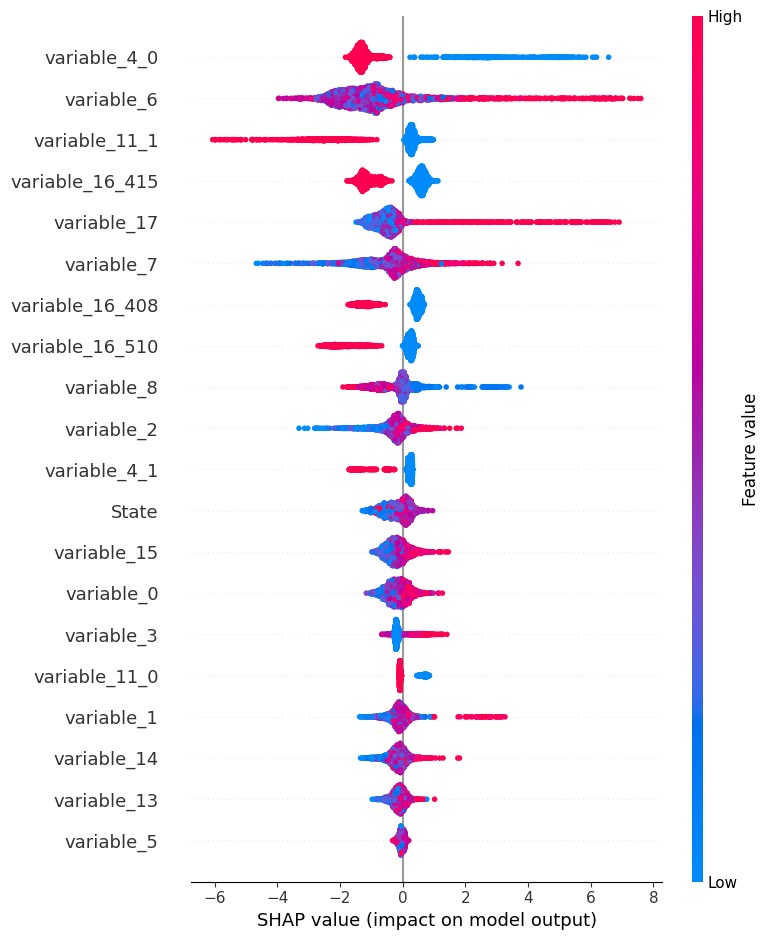

In [27]:
shap_values_plot(xgb_best_model, shap_data)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


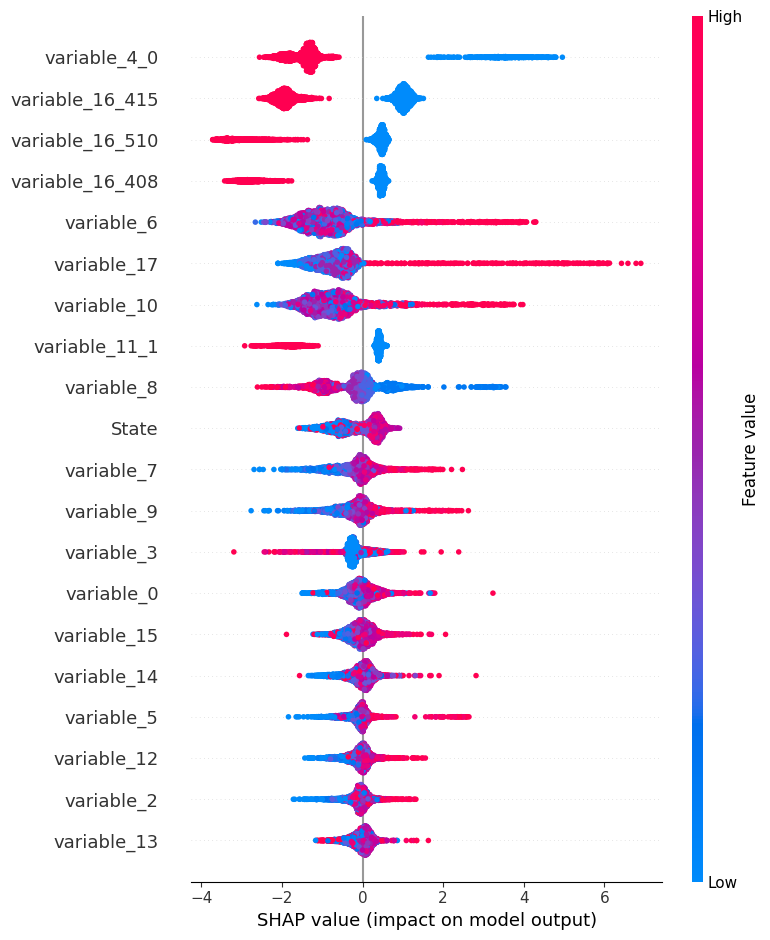

In [30]:
shap_values_plot(cb_best_model, shap_data)

1)The high values of the following variables


variable_17, variable_6, variable_10, variable_7, variable_9, variable_2 


increase the probability of responding to promotional offer

2)The value “1” of categorical variables

variable_4_0, variable_16_415, variable_16_510, variable_16_408, variable_11_1

decrease the probability of responding to promotional offer

3)low value of variable_8 increase the probability of promotional offer response

4)On the other hand, variables such as 

variable_13, variable_3, variable_14, State, variable_0

do not significantly and directly impact on promotional offer response probability

# Final modeling

By taking into consideration the results of RF, XGB, CatBoost , that’s more reliable to form an ensemble model, consisting of the latter models.

In [ ]:
voting = VotingClassifier(estimators=[('rf', rf_best_model), ('Xgb', xgb_best_model), 
                                      ('cb', cb_best_model), voting='soft'])

voting.fit(X_train, Y_train)
voting_pred = voting.predict(X_test)

In [32]:
voting_model_metrics = get_and_print_metrics(Y_test, voting_pred, voting, X_train, Y_train)
voting_model_metrics

Train f1_score: -  1.0
Test f1_score: -  0.92
confusion matrix
[[628  11]
 [ 20  91]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       639
           1       0.89      0.82      0.85       111

    accuracy                           0.96       750
   macro avg       0.93      0.90      0.92       750
weighted avg       0.96      0.96      0.96       750



{'f1_score': 0.92, 'precision': 0.89, 'recall': 0.82}

In [ ]:
experiment_name = "Experiment_6" 
run_name = "Voting_3_models_RF_XGB_CatBoost"
create_experiment(experiment_name, run_name, voting_model_metrics, voting)

# Probability prediction

In [33]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.head(3)

(333, 20)


,variable_0,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_9,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,State,ID
0,54,2.62,5.21,0,0,9.7,27.17,264.0,7,22.44,159.8,0,115.7,64,99,70,408,2,KY,3000
1,116,3.35,5.86,0,0,12.4,23.36,120.0,2,10.20,137.4,0,130.3,94,126,64,510,3,RI,3001
2,92,3.32,10.78,0,0,12.3,31.40,262.0,6,22.27,184.7,0,239.5,73,60,120,415,2,CO,3002


In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   variable_0   333 non-null    int64  
 1   variable_1   333 non-null    float64
 2   variable_2   333 non-null    float64
 3   variable_3   333 non-null    int64  
 4   variable_4   333 non-null    int64  
 5   variable_5   333 non-null    float64
 6   variable_6   333 non-null    float64
 7   variable_7   333 non-null    float64
 8   variable_8   333 non-null    int64  
 9   variable_9   333 non-null    float64
 10  variable_10  333 non-null    float64
 11  variable_11  333 non-null    int64  
 12  variable_12  333 non-null    float64
 13  variable_13  333 non-null    int64  
 14  variable_14  333 non-null    int64  
 15  variable_15  333 non-null    int64  
 16  variable_16  333 non-null    int64  
 17  variable_17  333 non-null    int64  
 18  State        333 non-null    object 
 19  ID      

In [35]:
logged_model = 'mlruns/Experiment_6_Voting_3_models_RF_XGB_CatBoost/f194f7a569174d528c0bb3a14f452dde/artifacts/model'
loaded_model = mlflow.sklearn.load_model(logged_model)

In [42]:
probability = get_probability(loaded_model, test_data, dummie_columns, enc_column)
probability

,Probability,ID
0,0.986960,3310
1,0.979634,3185
2,0.978693,3250
3,0.978453,3306
4,0.977514,3260
...,...,...
95,0.081935,3027
96,0.081866,3262
97,0.081526,3168
98,0.080507,3158
